# Анализ источников новостей

Цель данного исследования: проанализировать источники новостных лент, сравнить рубрики, подумать над возможностью добавление\удаление категорий для проекта "Радар новостей рунета"

In [1]:
import numpy as np
import pandas as pd
import datetime as DT
import matplotlib.pyplot as plt

In [1]:
from nltk import wordpunct_tokenize
from nltk import FreqDist

## RT

Загрузим датасет rt. Одновременно сделаем преобразование даты из строки

In [2]:
dateparse = lambda x: pd.datetime.strptime(x, "%Y-%m-%d %H:%M:%S")

In [3]:
data_rt = pd.read_csv('../data/rt.csv',
                      sep=',',
                      index_col=False,
                      escapechar='\\',
                      parse_dates=['date'],
                      date_parser=dateparse,
                      quotechar='\"')

In [4]:
# Проверим преобразование
data_rt.dtypes

date           datetime64[ns]
url                    object
edition                object
topics                 object
authors               float64
title                  object
text                   object
reposts_fb             object
reposts_vk             object
reposts_ok             object
reposts_twi            object
reposts_lj             object
reposts_tg             object
likes                  object
views                  object
comm_count             object
dtype: object

In [5]:
data_rt.shape

(106644, 16)

In [6]:
# Так выглядет датасет RT
data_rt.head()

,date,url,edition,topics,authors,title,text,reposts_fb,reposts_vk,reposts_ok,reposts_twi,reposts_lj,reposts_tg,likes,views,comm_count
0,2019-06-26 14:00:00,https://russian.rt.com/russia/news/644595-avto...,-,Россия,NaN,Эксперт прокомментировал ситуацию с возможным ...,"Как считает эксперт, россиянам не стоит пережи...",-,-,-,-,-,-,-,-,-
1,2019-06-26 19:56:00,https://russian.rt.com/sport/article/644740-nu...,-,Спорт,NaN,"Встреча Нурмагомедова с Макгрегором, восстанов...",«Конор может посетить поединок Хабиба с Порье»...,-,-,-,-,-,-,-,-,-
2,2019-06-26 14:52:00,https://russian.rt.com/russia/news/644619-puti...,-,Россия,NaN,Путин подарил Зюганову на юбилей материалы съе...,"Открывая заседание Госсовета в Кремле, Путин п...",-,-,-,-,-,-,-,-,-
3,2019-06-26 14:44:00,https://russian.rt.com/world/news/644618-parla...,-,Мир,NaN,"Парламентарии США, ФРГ и России проведут встре...",Об этом информируетnРИА Новостиnсо ссылкой на ...,-,-,-,-,-,-,-,-,-
4,2019-06-26 14:42:00,https://russian.rt.com/sport/news/644617-mok-a...,-,Спорт,NaN,МОК принял решение лишить признания AIBA,Решением 134-й сессии МОК в швейцарской Лозанн...,-,-,-,-,-,-,-,-,-


In [7]:
# Выясним в каким столбцах есть пустые данные
data_rt.isnull().any()

date           False
url            False
edition        False
topics         False
authors         True
title          False
text            True
reposts_fb     False
reposts_vk     False
reposts_ok     False
reposts_twi    False
reposts_lj     False
reposts_tg     False
likes          False
views          False
comm_count     False
dtype: bool

Как видим, в некоторых столбцах вместо значения Nan используется "-", их преобразованием займемся позже. А пока посмотрим строки, в которых пустые тексты новостей

In [8]:
print('Кол-во строк с значением NaN в столбце "Text" = ', data_rt['text'].isnull().sum())
data_rt[data_rt['text'].isnull()]

Кол-во строк с значением NaN в столбце "Text" =  12


,date,url,edition,topics,authors,title,text,reposts_fb,reposts_vk,reposts_ok,reposts_twi,reposts_lj,reposts_tg,likes,views,comm_count
37474,2019-06-05 13:47:00,https://russian.rt.com/russia/video/638188-obr...,-,Россия,NaN,\n В Дагестане люди пытаются вручну...,NaN,-,-,-,-,-,-,-,-,-
38249,2017-12-11 19:32:00,https://russian.rt.com/sport/article/459073-ro...,-,Спорт,NaN,Не без труда: Россия в овертайме победила Южну...,NaN,-,-,-,-,-,-,-,-,-
43956,2017-12-08 01:29:00,https://russian.rt.com/world/article/457555-la...,-,Мир,NaN,"Будущее Сирии, перенос столицы Израиля и ситуа...",NaN,-,-,-,-,-,-,-,-,-
84132,2016-07-29 10:08:01,https://russian.rt.com/article/314450-dollar-p...,-,Россия,NaN,Доллар превысил 67 рублей,NaN,-,-,-,-,-,-,-,-,-
86097,2016-07-27 11:24:00,https://russian.rt.com/article/314142-sbornaya...,-,Спорт,NaN,Сборная России по тхэквондо в полном составе д...,NaN,-,-,-,-,-,-,-,-,-
86103,2016-07-27 08:56:37,https://russian.rt.com/article/314121-cb-rf-ot...,-,Россия,NaN,ЦБ РФ отозвал лицензию у банка «БФГ-Кредит»,NaN,-,-,-,-,-,-,-,-,-
92836,2016-07-19 17:43:00,https://russian.rt.com/article/312972-mok-inic...,-,Спорт,NaN,МОК инициирует повторный анализ проб российски...,NaN,-,-,-,-,-,-,-,-,-
93872,2017-11-09 18:22:00,https://russian.rt.com/world/article/447764-ss...,-,Мир,NaN,«Это могла быть только внутренняя утечка»: экс...,NaN,-,-,-,-,-,-,-,-,-
93917,2016-07-18 16:47:26,https://russian.rt.com/article/312776-otchyot-...,-,Спорт,NaN,"Отчёт WADA: Метод, используемый ФСБ для вскрыт...",NaN,-,-,-,-,-,-,-,-,-
93919,2016-07-18 16:25:00,https://russian.rt.com/article/312771-otchyot-...,-,Спорт,NaN,Отчёт WADA: Минспорт РФ и ФСБ участвовали в за...,NaN,-,-,-,-,-,-,-,-,-


In [9]:
#Удалим эти строки
data_rt.drop(data_rt[data_rt.text.isnull()].index, inplace=True)

In [10]:
print('Кол-во строк с значением NaN в столбце "Text" = ', data_rt['text'].isnull().sum())

Кол-во строк с значением NaN в столбце "Text" =  0


Посмотрим сколько элементов Nan в столбце авторов

In [11]:
print('Кол-во строк с значением NaN в столбце "authors" = ', data_rt['authors'].isnull().sum())

Кол-во строк с значением NaN в столбце "authors" =  106632


Как видим все значения авторов Nan. Можно не использовать данные столбец

Посмотрим, что в столбцах, которые содержат дефис, как обозначение пустых данных

In [12]:
print('edition: ',data_rt['edition'].unique())
print('reposts_fb: ', data_rt['reposts_fb'].unique())
print('reposts_vk: ',data_rt['reposts_vk'].unique())
print('reposts_ok: ',data_rt['reposts_ok'].unique())
print('reposts_twi: ',data_rt['reposts_twi'].unique())
print('reposts_lj: ',data_rt['reposts_lj'].unique())
print('reposts_tg: ',data_rt['reposts_tg'].unique())
print('likes: ',data_rt['likes'].unique())
print('views: ',data_rt['views'].unique())
print('comm_count: ',data_rt['comm_count'].unique())

edition:  ['-']
reposts_fb:  ['-']
reposts_vk:  ['-']
reposts_ok:  ['-']
reposts_twi:  ['-']
reposts_lj:  ['-']
reposts_tg:  ['-']
likes:  ['-']
views:  ['-']
comm_count:  ['-']


Значений нет, можно удалять

In [95]:
# data_rt = data_rt.reindex()

In [13]:
#  Проверим повторяющиеся тексты
print('Кол-во одинаковых текстов:',data_rt.text.duplicated().sum())

Кол-во одинаковых текстов: 282


In [14]:
data_rt = data_rt.drop_duplicates(subset='text')

In [15]:
data_rt.shape

(106350, 16)

### Анализ дат

In [16]:
print('Минимальная дата в датасете:', data_rt.date.min())
print('Максимальная дата в датасете:', data_rt.date.max())

Минимальная дата в датасете: 2014-06-16 18:36:02
Максимальная дата в датасете: 2019-08-02 14:10:00


#### Распределение количества новостей по месяцам

In [17]:
# Вынесем месяц и год новости в отдельные столбцы
data_rt['month'] = data_rt.date.apply(lambda x: x.month)
data_rt['year'] = data_rt.date.apply(lambda x: x.year)

# Создадим отдельный датасет посчитаем количество новостей в разрезе месяца и года
df = data_rt.groupby(['year', 'month']).text.nunique().reset_index()

In [18]:
df

,year,month,text
0,2014,6,1
1,2014,9,396
2,2014,10,1036
3,2014,11,1389
4,2014,12,1657
5,2015,6,2020
6,2015,7,2092
7,2015,8,2207
8,2015,9,1229
9,2016,7,1921


In [19]:
df['month_year'] = df[['month', 'year']].apply(lambda x: '-'.join(['0'+str(x.month) if x.month<10 else str(x.month),
                                                                  str(x.year)]),
                                               axis =1)

In [20]:
df.columns = ['year', 'month', 'nunique_text', 'month_year']

In [21]:
# выберем только те месяцы, в которых количество новостей больше 10
df = df[df.nunique_text>10]

In [22]:
df[['month_year', 'nunique_text']].sort_values('nunique_text', ascending = False)

,month_year,nunique_text
29,05-2019,8268
20,12-2017,8266
26,11-2018,8130
22,05-2018,8088
19,11-2017,7793
30,06-2019,7538
15,06-2017,6999
14,05-2017,6080
25,10-2018,5233
27,12-2018,4474


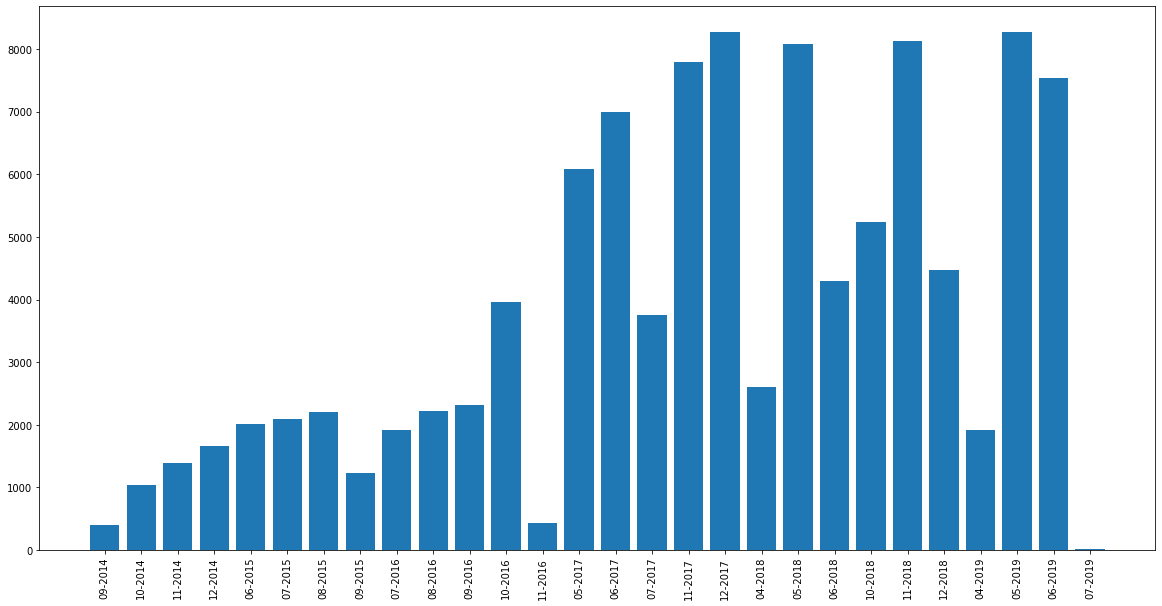

In [23]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.bar(x = df.month_year,
        height = df.nunique_text.values)
plt.xticks(rotation='vertical')
plt.show()

In [25]:
# Удалим часть символов

In [24]:
import re

In [47]:
data_rt.text = data_rt.text.apply(lambda x: re.sub("\«", "", x))

In [48]:
data_rt.text = data_rt.text.apply(lambda x: re.sub("\»", "", x))

In [49]:
data_rt.text = data_rt.text.apply(lambda x: re.sub("\%", "", x))

In [50]:
data_rt.text = data_rt.text.apply(lambda x: re.sub("\,", "", x))

In [51]:
data_rt.text = data_rt.text.apply(lambda x: re.sub("\.", "", x))

In [52]:
data_rt.text = data_rt.text.apply(lambda x: re.sub("\—", "", x))

In [53]:
data_rt.text = data_rt.text.apply(lambda x: re.sub("\-", "", x))

In [54]:
data_rt.text = data_rt.text.apply(lambda x: re.sub("\:", "", x))

In [55]:
data_rt.text = data_rt.text.apply(lambda x: re.sub("\n", "", x))

In [57]:
data_rt.text = data_rt.text.apply(lambda x: re.sub("\/", "", x))

In [58]:
data_rt.text = data_rt.text.apply(lambda x: re.sub("\?", "", x))

In [65]:
data_rt.text = data_rt.text.apply(lambda x: re.sub("\)", "", x))

In [66]:
data_rt.text = data_rt.text.apply(lambda x: re.sub("\(", "", x))

In [79]:
data_rt.text = data_rt.text.apply(lambda x: re.sub("\"", "", x))

In [80]:
data_rt.text = data_rt.text.apply(lambda x: re.sub("\''", "", x))

In [81]:
data_rt.text = data_rt.text.apply(lambda x: re.sub("\'", "", x))

In [82]:
data_rt.text = data_rt.text.apply(lambda x: re.sub("\#", "", x))

In [83]:
data_rt.text = data_rt.text.apply(lambda x: re.sub("\;", "", x))

In [87]:
data_rt.text = data_rt.text.apply(lambda x: re.sub("\@", "", x))

In [ ]:
data_ria.text = data_ria.text.apply(lambda x: re.sub("\–", "", x))

In [31]:
def text_to_token(text):
    text = text.lower()
    return wordpunct_tokenize(text)

In [32]:
def data_withoun_stopwords(text):
    text = [token for token in text if token not in stopwords]
    return text

In [73]:
dictionary_with_stopwords = FreqDist()

In [88]:
dictionary_without_stopwords = FreqDist()

In [75]:
for token in data_rt.text.values:
    dictionary_with_stopwords.update(text_to_token(token))

In [43]:
stopwords = open('../nlp/preprocessing/stopwords.txt', 'r')
stopwords = stopwords.read().split('\n')
stopwords += ["c","а","алло","без","белый","близко","более","больше","большой","будем","будет","будете","будешь","будто","буду","будут","будь","бы","бывает","бывь","был","была","были","было","быть","в","важная","важное","важные","важный","вам","вами","вас","ваш","ваша","ваше","ваши","вверх","вдали","вдруг","ведь","везде","вернуться","весь","вечер","взгляд","взять","вид","видел","видеть","вместе","вне","вниз","внизу","во","вода","война","вокруг","вон","вообще","вопрос","восемнадцатый","восемнадцать","восемь","восьмой","вот","впрочем","времени","время","все","все еще","всегда","всего","всем","всеми","всему","всех","всею","всю","всюду","вся","всё","второй","вы","выйти","г","где","главный","глаз","говорил","говорит","говорить","год","года","году","голова","голос","город","да","давать","давно","даже","далекий","далеко","дальше","даром","дать","два","двадцатый","двадцать","две","двенадцатый","двенадцать","дверь","двух","девятнадцатый","девятнадцать","девятый","девять","действительно","дел","делал","делать","делаю","дело","день","деньги","десятый","десять","для","до","довольно","долго","должен","должно","должный","дом","дорога","друг","другая","другие","других","друго","другое","другой","думать","душа","е","его","ее","ей","ему","если","есть","еще","ещё","ею","её","ж","ждать","же","жена","женщина","жизнь","жить","за","занят","занята","занято","заняты","затем","зато","зачем","здесь","земля","знать","значит","значить","и","иди","идти","из","или","им","имеет","имел","именно","иметь","ими","имя","иногда","их","к","каждая","каждое","каждые","каждый","кажется","казаться","как","какая","какой","кем","книга","когда","кого","ком","комната","кому","конец","конечно","которая","которого","которой","которые","который","которых","кроме","кругом","кто","куда","лежать","лет","ли","лицо","лишь","лучше","любить","люди","м","маленький","мало","мать","машина","между","меля","менее","меньше","меня","место","миллионов","мимо","минута","мир","мира","мне","много","многочисленная","многочисленное","многочисленные","многочисленный","мной","мною","мог","могу","могут","мож","может","может быть","можно","можхо","мои","мой","мор","москва","мочь","моя","моё","мы","на","наверху","над","надо","назад","наиболее","найти","наконец","нам","нами","народ","нас","начала","начать","наш","наша","наше","наши","не","него","недавно","недалеко","нее","ней","некоторый","нельзя","нем","немного","нему","непрерывно","нередко","несколько","нет","нею","неё","ни","нибудь","ниже","низко","никакой","никогда","никто","никуда","ним","ними","них","ничего","ничто","но","новый","нога","ночь","ну","нужно","нужный","нх","о","об","оба","обычно","один","одиннадцатый","одиннадцать","однажды","однако","одного","одной","оказаться","окно","около","он","она","они","оно","опять","особенно","остаться","от","ответить","отец","откуда","отовсюду","отсюда","очень","первый","перед","писать","плечо","по","под","подойди","подумать","пожалуйста","позже","пойти","пока","пол","получить","помнить","понимать","понять","пор","пора","после","последний","посмотреть","посреди","потом","потому","почему","почти","правда","прекрасно","при","про","просто","против","процентов","путь","пятнадцатый","пятнадцать","пятый","пять","работа","работать","раз","разве","рано","раньше","ребенок","решить","россия","рука","русский","ряд","рядом","с","с кем","сам","сама","сами","самим","самими","самих","само","самого","самой","самом","самому","саму","самый","свет","свое","своего","своей","свои","своих","свой","свою","сделать","сеаой","себе","себя","сегодня","седьмой","сейчас","семнадцатый","семнадцать","семь","сидеть","сила","сих","сказал","сказала","сказать","сколько","слишком","слово","случай","смотреть","сначала","снова","со","собой","собою","советский","совсем","спасибо","спросить","сразу","стал","старый","стать","стол","сторона","стоять","страна","суть","считать","т","та","так","такая","также","таки","такие","такое","такой","там","твои","твой","твоя","твоё","те","тебе","тебя","тем","теми","теперь","тех","то","тобой","тобою","товарищ","тогда","того","тоже","только","том","тому","тот","тою","третий","три","тринадцатый","тринадцать","ту","туда","тут","ты","тысяч","у","увидеть","уж","уже","улица","уметь","утро","хороший","хорошо","хотел бы","хотеть","хоть","хотя","хочешь","час","часто","часть","чаще","чего","человек","чем","чему","через","четвертый","четыре","четырнадцатый","четырнадцать","что","чтоб","чтобы","чуть","шестнадцатый","шестнадцать","шестой","шесть","эта","эти","этим","этими","этих","это","этого","этой","этом","этому","этот","эту","я","являюсь"]

In [89]:
for token in data_rt.text.values:
    dictionary_without_stopwords.update(data_withoun_stopwords(text_to_token(token)))

In [91]:
# Посмотрим 20 самых популярных слов без удаления стопслов и построим по ним график
dictionary_with_stopwords.most_common(20)

[('в', 594626),
 ('и', 327685),
 ('на', 262419),
 ('что', 223736),
 ('с', 165109),
 ('не', 147120),
 ('по', 126972),
 ('о', 58621),
 ('для', 57277),
 ('это', 55732),
 ('к', 54459),
 ('из', 54078),
 ('за', 52518),
 ('как', 51321),
 ('а', 50264),
 ('россии', 49599),
 ('его', 45069),
 ('он', 41898),
 ('от', 40426),
 ('но', 39725)]

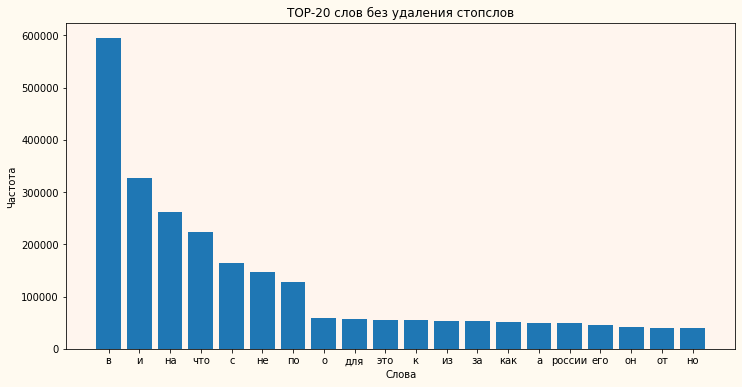

In [92]:
x = dict(dictionary_with_stopwords.most_common(20)).keys()
y = dict(dictionary_with_stopwords.most_common(20)).values()

fig, ax = plt.subplots()

ax.bar(x, y)
ax.set_title('TOP-20 слов без удаления стопслов')
ax.set_ylabel('Частота')
ax.set_xlabel('Слова')

ax.set_facecolor('seashell')
fig.set_facecolor('floralwhite')
fig.set_figwidth(12)    #  ширина Figure
fig.set_figheight(6)    #  высота Figure


plt.show()

In [90]:
# Посмотрим 20 самых популярных слов после удаления стопслов и построим по ним график
dictionary_without_stopwords.most_common(20)

[('россии', 49591),
 ('сша', 33885),
 ('заявил', 23648),
 ('словам', 21881),
 ('отметил', 20345),
 ('украины', 13998),
 ('слова', 13330),
 ('приводит', 12552),
 ('страны', 11999),
 ('2017', 11767),
 ('rt', 11739),
 ('мая', 11358),
 ('решение', 11216),
 ('цитирует', 11163),
 ('сообщалось', 10854),
 ('добавил', 10827),
 ('тыс', 10598),
 ('2018', 10395),
 ('риа', 10358),
 ('достаточно', 10191)]

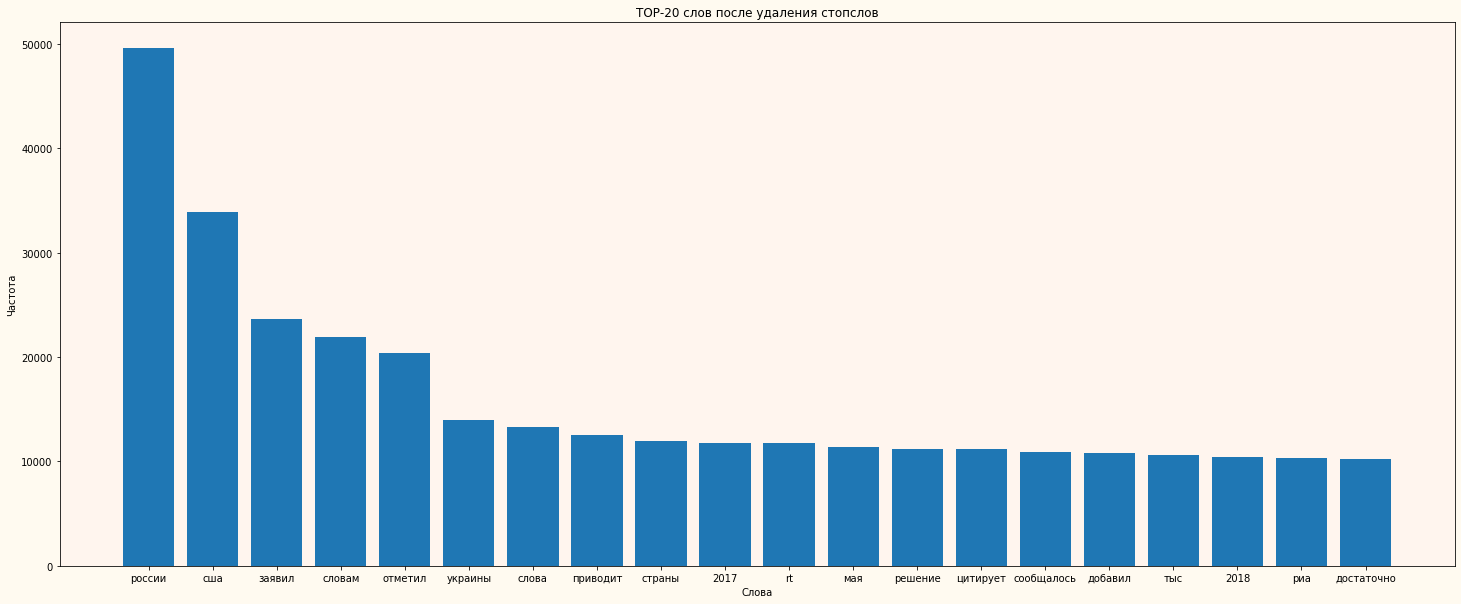

In [96]:
x = dict(dictionary_without_stopwords.most_common(20)).keys()
y = dict(dictionary_without_stopwords.most_common(20)).values()

fig, ax = plt.subplots()

ax.bar(x, y)
ax.set_title('TOP-20 слов после удаления стопслов')
ax.set_ylabel('Частота')
ax.set_xlabel('Слова')

ax.set_facecolor('seashell')
fig.set_facecolor('floralwhite')
fig.set_figwidth(25)    #  ширина Figure
fig.set_figheight(10)    #  высота Figure


plt.show()

### Рубрики RT

In [97]:
# Считаем количество рубрик в данном датасете, а также выведем значения
print('Количество рубрик = ', data_rt.topics.unique().shape)
data_rt['topics'].unique()

Количество рубрик =  (10,)


array(['Россия', 'Спорт', 'Мир', 'Без политики', 'Новости партнёров',
       'Бывший СССР', 'Экономика', 'Наука', 'Мероприятия RT',
       'Пресс-релизы'], dtype=object)

Все рубрики, с количеством новостей в каждой группе

In [98]:
data_rt.groupby('topics')['topics'].count().sort_values(ascending=False)

topics
Россия               32864
Спорт                26678
Мир                  26369
Бывший СССР          10074
Без политики          4437
Экономика             4316
Наука                 1493
Пресс-релизы            92
Новости партнёров       14
Мероприятия RT          13
Name: topics, dtype: int64